<a href="https://colab.research.google.com/github/ajaytelukutla19/parkinson_mri_detector/blob/main/MRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
irfansheriff_parkinsons_brain_mri_dataset_path = kagglehub.dataset_download('irfansheriff/parkinsons-brain-mri-dataset')

print('Data source import complete.')


Data source import complete.


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
plt.rcParams["font.size"] = 8
# Instead of:
# from keras.preprocessing.image import ImageDataGenerator

# Use:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os

# Set paths
data_dir = "/kaggle/input/parkinsons-brain-mri-dataset/parkinsons_dataset"  # <-- Replace with your dataset path

# Parameters
batch_size = 32
img_size = (224, 224)
seed = 42

# Load datasets
train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

# Optional: Test split (if needed)
# You can split validation later for testing or reserve a separate set.

# Class names
class_names = train_ds.class_names
print("Classes:", class_names)

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Normalization layer
normalization_layer = Rescaling(1./255)

# Apply normalization
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


Found 831 files belonging to 2 classes.
Using 665 files for training.
Found 831 files belonging to 2 classes.
Using 166 files for validation.
Classes: ['normal', 'parkinson']


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0

# Data Augmentation
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

# Build the model
base_model = EfficientNetB0(input_shape=(224, 224, 3),
                            include_top=False,
                            weights='imagenet')  # Transfer learning

base_model.trainable = False  # Freeze base model

# Model architecture
model = Sequential([
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Extract class labels from training dataset
y_train = np.concatenate([y.numpy() for _, y in train_ds])

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = {i: w for i, w in enumerate(class_weights)}
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(0.684156378600823), 1: np.float64(1.8575418994413408)}


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Save best model
checkpoint_cb = ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_loss', mode='min')

# Stop if no improvement
earlystop_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

callbacks = [checkpoint_cb, earlystop_cb]


In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.2832 - auc: 0.5075 - loss: 0.7268

21/21 ━━━━━━━━━━━━━━━━━━━━ 29s 339ms/step - accuracy: 0.2831 - auc: 0.5076 - loss: 0.7265 - val_accuracy: 0.2530 - val_auc: 0.5000 - val_loss: 0.7680
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.3151 - auc: 0.4778 - loss: 0.7005

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.3166 - auc: 0.4779 - loss: 0.7007 - val_accuracy: 0.2530 - val_auc: 0.5000 - val_loss: 0.7140
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4616 - auc: 0.4938 - loss: 0.7043

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.4617 - auc: 0.4950 - loss: 0.7038 - val_accuracy: 0.2530 - val_auc: 0.5403 - val_loss: 0.7011
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.4838 - auc: 0.5155 - loss: 0.7063

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.4831 - auc: 0.5154 - loss: 0.7058 - val_accuracy: 0.2530 - val_auc: 0.5626 - val_loss: 0.6952
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.4860 - auc: 0.5249 - loss: 0.6833

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.4864 - auc: 0.5242 - loss: 0.6838 - val_accuracy: 0.7470 - val_auc: 0.5000 - val_loss: 0.6849
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.5202 - auc: 0.4830 - loss: 0.6884 - val_accuracy: 0.7470 - val_auc: 0.5000 - val_loss: 0.6914
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.5091 - auc: 0.4998 - loss: 0.6892 - val_accuracy: 0.2530 - val_auc: 0.5712 - val_loss: 0.6956
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.4372 - auc: 0.4549 - loss: 0.7020 - val_accuracy: 0.7470 - val_auc: 0.5000 - val_loss: 0.6921
Epoch 9/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.4769 - auc: 0.4713 - loss: 0.7096 - val_accuracy: 0.2530 - val_auc: 0.5000 - val_loss: 0.6969
Epoch 10/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.4436 - auc: 0.4721 - loss: 0.7021 - val_accuracy: 0.7470 - val_auc: 0.5161 - val_loss: 0.6912


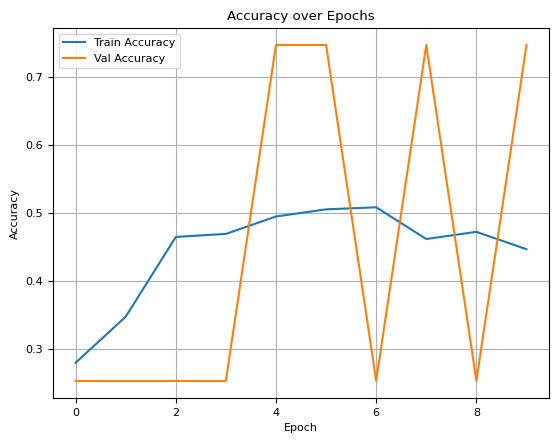

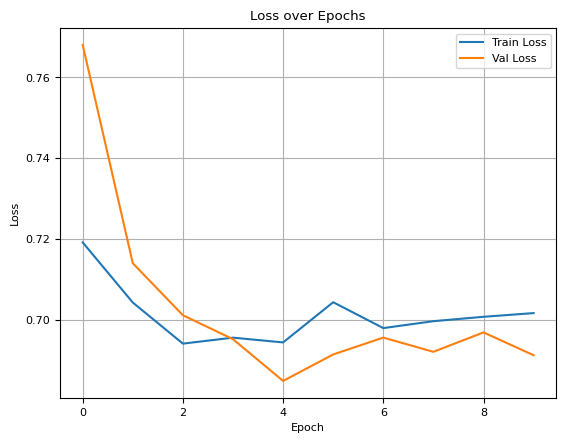

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
val_loss, val_accuracy, val_auc = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation AUC: {val_auc:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7637 - auc: 0.5000 - loss: 0.6843
Validation Accuracy: 0.7470
Validation AUC: 0.5000


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 475ms/step
              precision    recall  f1-score   support

      normal       0.75      1.00      0.86       124
   parkinson       0.00      0.00      0.00        42

    accuracy                           0.75       166
   macro avg       0.37      0.50      0.43       166
weighted avg       0.56      0.75      0.64       166



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


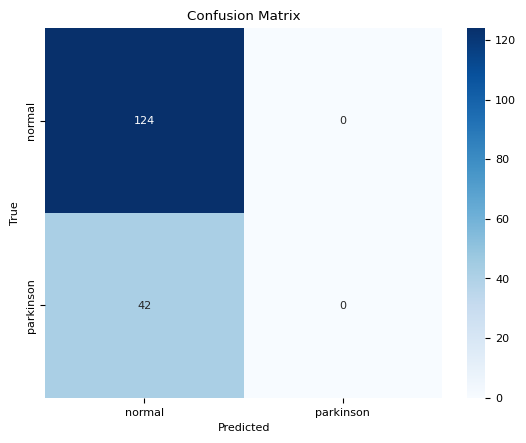

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get true labels and predictions
y_true = np.concatenate([y.numpy() for _, y in val_ds])
y_pred_probs = model.predict(val_ds)
y_pred = (y_pred_probs > 0.5).astype("int32")

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from tensorflow.keras.applications import DenseNet201, ResNet152V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# === Parameters ===
IMG_SIZE = 224
BATCH_SIZE = 32

# === Data Preparation ===
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.3,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    '/kaggle/input/parkinsons-brain-mri-dataset/parkinsons_dataset',  # <- replace with actual dataset folder path
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    '/kaggle/input/parkinsons-brain-mri-dataset/parkinsons_dataset',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# === Model Builder ===
def build_model(base_model_class, input_shape, num_classes):
    base_model = base_model_class(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model, base_model

# === Training ===
def train_and_evaluate(model, base_model, name):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
    ]
    print(f"\n--- Training {name} ---")
    model.fit(train_generator, validation_data=val_generator, epochs=10, callbacks=callbacks)

    # Unfreeze top layers of the base model
    base_model.trainable = True
    for layer in base_model.layers[:-40]:
        layer.trainable = False
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(train_generator, validation_data=val_generator, epochs=10, callbacks=callbacks)

    val_loss, val_acc = model.evaluate(val_generator)
    print(f"\n✅ {name} Final Validation Accuracy: {val_acc * 100:.2f}%")

    Y_pred = model.predict(val_generator)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = val_generator.classes
    class_labels = list(val_generator.class_indices.keys())

    print(f"\n{name} Classification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title(f"{name} Confusion Matrix")
    plt.tight_layout()
    plt.show()

# === Try DenseNet201 ===
densenet_model, densenet_base = build_model(DenseNet201, (IMG_SIZE, IMG_SIZE, 3), train_generator.num_classes)
train_and_evaluate(densenet_model, densenet_base, "DenseNet201")

# === Try ResNet152V2 ===
resnet_model, resnet_base = build_model(ResNet152V2, (IMG_SIZE, IMG_SIZE, 3), train_generator.num_classes)
train_and_evaluate(resnet_model, resnet_base, "ResNet152V2")


Found 665 images belonging to 2 classes.
Found 166 images belonging to 2 classes.
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

--- Training DenseNet201 ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 176s 7s/step - accuracy: 0.6893 - loss: 0.7477 - val_accuracy: 0.8193 - val_loss: 0.3854 - learning_rate: 0.0010
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 154s 7s/step - accuracy: 0.8503 - loss: 0.3067 - val_accuracy: 0.7892 - val_loss: 0.4803 - learning_rate: 0.0010
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 144s 7s/step - accuracy: 0.8707 - loss: 0.2801 - val_accuracy: 0.7892 - val_loss: 0.3427 - learning_rate: 0.0010
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 144s 7s/step - accuracy: 0.9162 - loss: 0.2074 - val_accuracy: 0.8373 - val_loss: 0.3348 - learning_rate: 0.0010
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 144s 7s/step - accuracy: 0.9400 - loss: 0.1761 - val_accuracy: 0.8494 - val_loss: 0.3336 - learning_rate: 0.0010
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 143s 7s/step - accuracy: 0.9299 - loss: 0.1667 - val_accuracy: 0.8193 - val_loss: 0.3730 - learning_rate: 0.0010
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 156s 8s/step - accuracy: 0.9292 - loss: 0.1656 - val_acc

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import random

# === Parameters ===
IMG_SIZE = 299  # Required for InceptionResNetV2
BATCH_SIZE = 32

# === Data Preparation with Basic Augmentation ===
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_data = datagen.flow_from_directory(
    'dataset_path_here',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_data = datagen.flow_from_directory(
    'dataset_path_here',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# === CutMix & MixUp Augmentation ===
def sample_beta_distribution(size, concentration=0.2):
    gamma_1 = np.random.gamma(concentration, 1, size)
    gamma_2 = np.random.gamma(concentration, 1, size)
    return gamma_1 / (gamma_1 + gamma_2)

def get_mixup_data(images, labels):
    lam = sample_beta_distribution(1)[0]
    batch_size = images.shape[0]
    index = np.random.permutation(batch_size)
    mixed_images = lam * images + (1 - lam) * images[index]
    mixed_labels = lam * labels + (1 - lam) * labels[index]
    return mixed_images, mixed_labels

def mixup_generator(generator):
    while True:
        x, y = generator.next()
        x, y = get_mixup_data(x, y)
        yield x, y

# === Build Model with InceptionResNetV2 ===
def build_model(input_shape, num_classes):
    base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model, base_model

# === Train and Evaluate ===
def train_and_evaluate(model, base_model, name):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
    ]
    print(f"\n--- Training {name} ---")
    model.fit(mixup_generator(train_data), steps_per_epoch=len(train_data), validation_data=val_data, epochs=10, callbacks=callbacks)

    # Fine-tuning
    base_model.trainable = True
    for layer in base_model.layers[:-40]:
        layer.trainable = False
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(mixup_generator(train_data), steps_per_epoch=len(train_data), validation_data=val_data, epochs=10, callbacks=callbacks)

    val_loss, val_acc = model.evaluate(val_data)
    print(f"\n✅ {name} Final Validation Accuracy: {val_acc * 100:.2f}%")

    Y_pred = model.predict(val_data)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = val_data.classes
    class_labels = list(val_data.class_indices.keys())

    print(f"\n{name} Classification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title(f"{name} Confusion Matrix")
    plt.tight_layout()
    plt.show()

# === Run Model ===
model, base = build_model((IMG_SIZE, IMG_SIZE, 3), train_data.num_classes)
train_and_evaluate(model, base, "InceptionResNetV2 with MixUp")


Found 665 images belonging to 2 classes.
Found 166 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,517,442 (24.86 MB)

 Trainable params: 6,516,994 (24.86 MB)

 Non-trainable params: 448 (1.75 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6544 - loss: 6.0294 - val_accuracy: 0.6024 - val_loss: 1.5574 - learning_rate: 0.0010
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7241 - loss: 1.6333 - val_accuracy: 0.5663 - val_loss: 4.1480 - learning_rate: 0.0010
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7357 - loss: 0.8624 - val_accuracy: 0.5663 - val_loss: 5.0513 - learning_rate: 0.0010
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7504 - loss: 0.6844 - val_accuracy: 0.5663 - val_loss: 6.7675 - learning_rate: 0.0010
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7688 - loss: 0.5589 - val_accuracy: 0.5663 - val_loss: 6.2479 - learning_rate: 2.0000e-04
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8314 - loss: 0.4026 - val_accuracy: 0.5663 - val_loss: 4.9914 - learning_rate: 2.0000e-04
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - accuracy: 0.3833 - loss: 2.4467

✅ DNN Final Valida

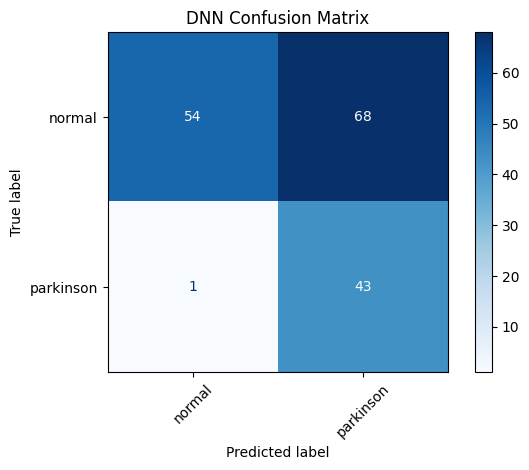

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# === Parameters ===
IMG_SIZE = 128  # Smaller size since we're training from scratch
BATCH_SIZE = 32

# === Data Preparation ===
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_data = datagen.flow_from_directory(
    '/kaggle/input/parkinsons-brain-mri-dataset/parkinsons_dataset',  # replace with your dataset path
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_data = datagen.flow_from_directory(
    '/kaggle/input/parkinsons-brain-mri-dataset/parkinsons_dataset',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# === Build a DNN (CNN-style) from scratch ===
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_data.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# === Callbacks ===
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]

# === Training ===
model.fit(train_data, validation_data=val_data, epochs=20, callbacks=callbacks)

# === Evaluation ===
val_loss, val_acc = model.evaluate(val_data)
print(f"\n✅ DNN Final Validation Accuracy: {val_acc * 100:.2f}%")

# === Confusion Matrix & Classification Report ===
Y_pred = model.predict(val_data)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_data.classes
class_labels = list(val_data.class_indices.keys())

print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("DNN Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
# InceptionResNetV2 with CBAM + MixUp
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Multiply, Conv2D, Activation, Add, Lambda, Reshape, GlobalMaxPooling2D, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

IMG_SIZE = 299
BATCH_SIZE = 32

# === MixUp Generator ===
def mixup_generator(generator, alpha=0.4):
    while True:
        x, y = next(generator)
        lam = np.random.beta(alpha, alpha)
        index = np.random.permutation(x.shape[0])
        x_mix = lam * x + (1 - lam) * x[index]
        y_mix = lam * y + (1 - lam) * y[index]
        yield x_mix, y_mix

# === CBAM Block ===
def cbam_block(feature_map, ratio=8):
    channel = feature_map.shape[-1]

    shared_layer_one = Dense(channel//ratio, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    shared_layer_two = Dense(channel, kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(feature_map)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(feature_map)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)
    channel_refined = Multiply()([feature_map, cbam_feature])

    return channel_refined

# === Data Generators ===
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)
train_gen = datagen.flow_from_directory(
    '/kaggle/input/parkinsons-brain-mri-dataset/parkinsons_dataset',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)
val_gen = datagen.flow_from_directory(
    '/kaggle/input/parkinsons-brain-mri-dataset/parkinsons_dataset
    ',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# === Model ===
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False
x = base_model.output
x = cbam_block(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(train_gen.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]

model.fit(
    mixup_generator(train_gen),
    steps_per_epoch=len(train_gen),
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks
)

# === Evaluation ===
val_loss, val_acc = model.evaluate(val_gen)
print(f"\n✅ Final Validation Accuracy: {val_acc * 100:.2f}%")

Y_pred = model.predict(val_gen)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

Found 665 images belonging to 2 classes.
Found 166 images belonging to 2 classes.
Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.5430 - loss: 0.9998 - val_accuracy: 0.2771 - val_loss: 4.4145
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.5770 - loss: 0.9649 - val_accuracy: 0.7651 - val_loss: 0.5782
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.6861 - loss: 0.6978 - val_accuracy: 0.7229 - val_loss: 1.3909
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7096 - loss: 0.6241 - val_accuracy: 0.7470 - val_loss: 0.7455
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7298 - loss: 0.5745 - val_accuracy: 0.7952 - val_loss: 0.4034
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7268 - loss: 0.5897 - val_accuracy: 0.8253 - val_loss: 0.3840
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.7199 - loss: 0.5549 - val_accuracy: 0.8313 - val_loss: 0.3543
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━

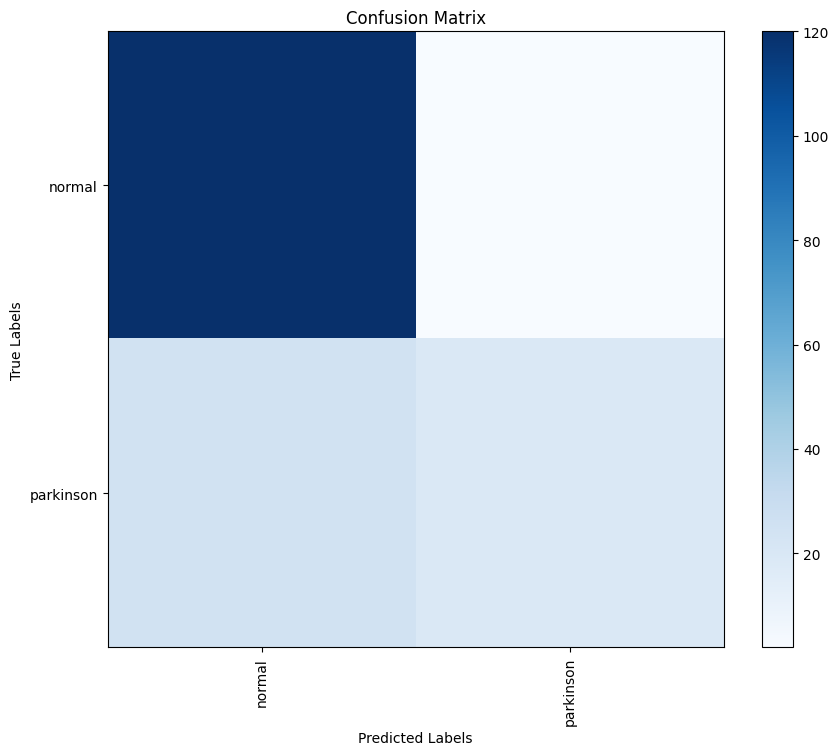

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# === Parameters ===
IMG_SIZE = 224
BATCH_SIZE = 32

# === Data Augmentation ===
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    '/kaggle/input/parkinsons-brain-mri-dataset/parkinsons_dataset',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    '/kaggle/input/parkinsons-brain-mri-dataset/parkinsons_dataset',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# === Deep Dense Neural Network (DNN) ===
model = Sequential([
    Flatten(input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# === Training ===
history = model.fit(train_generator, validation_data=val_generator, epochs=30)

# === Evaluation ===
val_loss, val_acc = model.evaluate(val_generator)
print(f"✅ Final Validation Accuracy: {val_acc * 100:.2f}%")

# === Classification Report ===
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

print("\nClassification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_labels))

# === Confusion Matrix ===
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.colorbar()
plt.xticks(ticks=np.arange(len(class_labels)), labels=class_labels, rotation=90)
plt.yticks(ticks=np.arange(len(class_labels)), labels=class_labels)
plt.show()


Found 665 images belonging to 2 classes.
Found 166 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.5527 - loss: 1.0811 - val_accuracy: 0.7410 - val_loss: 2.3103
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6457 - loss: 0.7622 - val_accuracy: 0.7349 - val_loss: 2.8388
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.6886 - loss: 0.6847 - val_accuracy: 0.7289 - val_loss: 1.6594
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7075 - loss: 0.6293 - val_accuracy: 0.7651 - val_loss: 0.9585
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7242 - loss: 0.5499 - val_accuracy: 0.7831 - val_loss: 0.6588
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7687 - loss: 0.5289 - val_accuracy: 0.8133 - val_loss: 0.5850
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.7739 - loss: 0.4783 - val_accuracy: 0.8072 - val_loss: 0.4534
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8048 - loss: 0.4725 - val_accuracy: 0.9157 - val_loss:

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 359ms/step

Classification Report:
               precision    recall  f1-score   support

      normal       0.87      0.81      0.84       122
   parkinson       0.56      0.66      0.60        44

    accuracy                           0.77       166
   macro avg       0.71      0.74      0.72       166
weighted avg       0.79      0.77      0.78       166



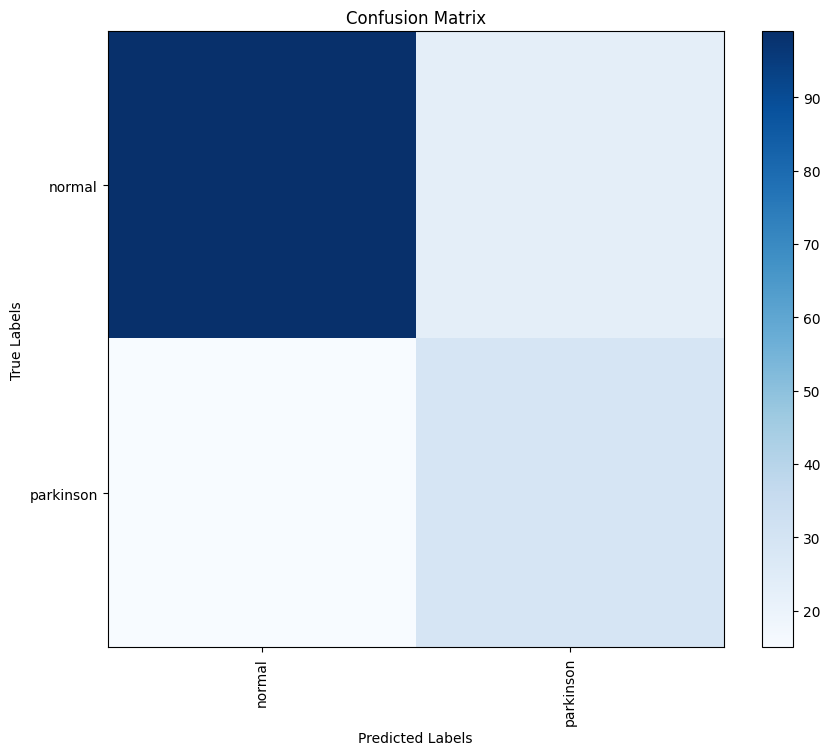

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# === Parameters ===
IMG_SIZE = 224
BATCH_SIZE = 32

# === Data Augmentation ===
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    '/kaggle/input/parkinsons-brain-mri-dataset/parkinsons_dataset',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    '/kaggle/input/parkinsons-brain-mri-dataset/parkinsons_dataset',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# === Deep Dense Neural Network (DNN) ===
model = Sequential([
    Flatten(input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# === Training ===
history = model.fit(train_generator, validation_data=val_generator, epochs=30)

# === Evaluation ===
val_loss, val_acc = model.evaluate(val_generator)
print(f"✅ Final Validation Accuracy: {val_acc * 100:.2f}%")

# === Classification Report ===
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

print("\nClassification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_labels))

# === Confusion Matrix ===
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.colorbar()
plt.xticks(ticks=np.arange(len(class_labels)), labels=class_labels, rotation=90)
plt.yticks(ticks=np.arange(len(class_labels)), labels=class_labels)
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.utils import class_weight
import numpy as np

# === Step 1: Load Dataset ===
data_dir = "/kaggle/input/parkinsons-brain-mri-dataset/parkinsons_dataset"  # <-- Replace this
batch_size = 32
img_size = (224, 224)

train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names

# Normalize images
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# === Step 2: Compute Class Weights ===
y_train = np.concatenate([y.numpy() for _, y in train_ds])
class_weights_arr = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: w for i, w in enumerate(class_weights_arr)}

# === Step 3: AlexNet-Style Model ===
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    layers.Conv2D(96, (11, 11), strides=(4, 4), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    layers.Conv2D(256, (5, 5), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    layers.Conv2D(384, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Conv2D(384, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Conv2D(256, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    layers.Flatten(),

    layers.Dense(4096),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(4096),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# === Step 4: Compile Model ===
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# === Step 5: Callbacks ===
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alexnet_best_model.h5", save_best_only=True, monitor='val_loss', mode='min')
earlystop_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# === Step 6: Train ===
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=201,  # as per your request
    class_weight=class_weights,
    callbacks=[checkpoint_cb, earlystop_cb]
)

# === Step 7: Evaluate ===
val_loss, val_acc, val_auc = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc:.4f}, AUC: {val_auc:.4f}")


Found 831 files belonging to 2 classes.
Using 665 files for training.
Found 831 files belonging to 2 classes.
Using 166 files for validation.
Epoch 1/201
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.6921 - auc: 0.8680 - loss: 0.5864

21/21 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6962 - auc: 0.8708 - loss: 0.5788 - val_accuracy: 0.7470 - val_auc: 0.6841 - val_loss: 0.5611
Epoch 2/201
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.9349 - auc: 0.9882 - loss: 0.1376 - val_accuracy: 0.7470 - val_auc: 0.8367 - val_loss: 0.8108
Epoch 3/201
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.9835 - auc: 0.9991 - loss: 0.0426 - val_accuracy: 0.7470 - val_auc: 0.6423 - val_loss: 1.0271
Epoch 4/201
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.9816 - auc: 0.9992 - loss: 0.0423 - val_accuracy: 0.7470 - val_auc: 0.5000 - val_loss: 1.9217
Epoch 5/201
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.9954 - auc: 1.0000 - loss: 0.0114 - val_accuracy: 0.7470 - val_auc: 0.5000 - val_loss: 1.8831
Epoch 6/201
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.9998 - auc: 1.0000 - loss: 0.0085 - val_accuracy: 0.7470 - val_auc: 0.5000 - val_loss: 1.9286
Epoch 7/201
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step 

In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 591.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 110.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 97.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.9 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.utils import class_weight
import numpy as np
import os

# === Step 1: Load Dataset ===
data_dir = "/kaggle/input/parkinsons-brain-mri-dataset/parkinsons_dataset"
batch_size = 32
img_size = (224, 224)
seed = 42

train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

# === Step 2: Data Augmentation & Normalization ===
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(data_augmentation(x, training=True)), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# === Step 3: Class Weights ===
raw_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)
y_train = np.concatenate([y.numpy() for _, y in raw_ds])
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: w for i, w in enumerate(weights)}

# === Step 4: Custom Focal Loss ===
def focal_loss(alpha=0.25, gamma=2.0):
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1. - tf.keras.backend.epsilon())
        cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        weight = alpha * y_true * tf.pow(1 - y_pred, gamma) + (1 - alpha) * (1 - y_true) * tf.pow(y_pred, gamma)
        return tf.reduce_mean(weight * cross_entropy)
    return loss_fn

# === Step 5: AlexNet Model (Modified for 224x224) ===
def build_alexnet(input_shape=(224, 224, 3)):
    model = models.Sequential([
        layers.Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=2),

        layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=2),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(3, 3), strides=2),

        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    return model

model = build_alexnet()

# === Step 6: Compile ===
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=focal_loss(alpha=0.25, gamma=2.0),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# === Step 7: Checkpoint & LR Scheduler ===
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "alexnet_best_model.keras",
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# === Step 8: Train ===
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weights,
    callbacks=[checkpoint_cb, reduce_lr_cb]  # no earlystop
)

# === Step 9: Evaluate ===
val_loss, val_acc, val_auc = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc:.4f}, AUC: {val_auc:.4f}, Loss: {val_loss:.4f}")


Found 831 files belonging to 2 classes.
Using 665 files for training.
Found 831 files belonging to 2 classes.
Using 166 files for validation.
Found 831 files belonging to 2 classes.
Using 665 files for training.
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6513 - auc: 0.5111 - loss: 0.3780 - val_accuracy: 0.7470 - val_auc: 0.6285 - val_loss: 0.0996 - learning_rate: 1.0000e-04
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 29s 827ms/step - accuracy: 0.7396 - auc: 0.7965 - loss: 0.0477 - val_accuracy: 0.7470 - val_auc: 0.7926 - val_loss: 0.0836 - learning_rate: 1.0000e-04
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 452ms/step - accuracy: 0.8143 - auc: 0.9148 - loss: 0.0340 - val_accuracy: 0.7470 - val_auc: 0.8519 - val_loss: 0.0859 - learning_rate: 1.0000e-04
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 461ms/step - accuracy: 0.8815 - auc: 0.9571 - loss: 0.0250 - val_accuracy: 0.7771 - val_auc: 0.8302 - val_loss: 0.0904 - learning_rate: 1.0000e-04
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 716ms/step - accuracy: 0.9143 - auc: 0.9733 - loss: 0.0208 - val_accuracy: 0.7470 - val_auc: 0.8379 - val_loss: 0.0799 - learning_rate: 5.0000e-05
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 692ms/step - accuracy: 0.93

In [ ]:
from graphviz import Digraph

dot = Digraph(comment='Parkinsons MRI Classification Flowchart', format='png')

# Step Nodes
dot.node('A', 'Step 1:\nLoad Dataset\n(80% Train, 20% Val)', shape='box')
dot.node('B', 'Step 2:\nData Augmentation & Normalization', shape='box')
dot.node('C', 'Step 3:\nCompute Class Weights', shape='box')
dot.node('D', 'Step 4:\nDefine Focal Loss', shape='box')
dot.node('E', 'Step 5:\nBuild AlexNet Model\n(224x224 Input, 5 Conv Layers)', shape='box')
dot.node('F', 'Step 6:\nCompile Model\n(Adam + Focal Loss)', shape='box')
dot.node('G', 'Step 7:\nDefine Callbacks\n(ModelCheckpoint, ReduceLROnPlateau)', shape='box')
dot.node('H', 'Step 8:\nTrain Model\n(30 Epochs)', shape='box')
dot.node('I', 'Step 9:\nEvaluate Model\n(Accuracy, AUC, Loss)', shape='box')
dot.node('J', 'Step 10:\nConfusion Matrix\n(Display Results)', shape='box')
dot.node('K', 'END:\nSave Best Model + Metrics', shape='ellipse')

# Connecting Arrows
dot.edges(['AB', 'BC', 'CD', 'DE', 'EF', 'FG', 'GH', 'HI', 'IJ', 'JK'])

# Save and render
dot.render('parkinsons_mri_flowchart', view=True)


Found 831 files belonging to 2 classes.
Using 665 files for training.
Found 831 files belonging to 2 classes.
Using 166 files for validation.
Found 831 files belonging to 2 classes.
Using 665 files for training.
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 752ms/step - accuracy: 0.6655 - auc: 0.5238 - loss: 0.2735 - val_accuracy: 0.7470 - val_auc: 0.7650 - val_loss: 0.1020 - learning_rate: 1.0000e-04
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 703ms/step - accuracy: 0.7704 - auc: 0.7424 - loss: 0.0543 - val_accuracy: 0.7470 - val_auc: 0.7488 - val_loss: 0.0899 - learning_rate: 1.0000e-04
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 694ms/step - accuracy: 0.7922 - auc: 0.9050 - loss: 0.0366 - val_accuracy: 0.7470 - val_auc: 0.7897 - val_loss: 0.0897 - learning_rate: 1.0000e-04
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 876ms/step - accuracy: 0.8721 - auc: 0.9595 - loss: 0.0249 - val_accuracy: 0.7470 - val_auc: 0.7398 - val_loss: 0.0865 - learning_rate: 1.0000e-04
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 428ms/step - accuracy: 0.9044 - auc: 0.9664 - loss: 0.0238 - val_accuracy: 0.7892 - val_auc: 0.7682 - val_loss: 0.0890 - learning_rate: 1.0000e-04
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 405ms/step - accuracy: 0.

<Figure size 600x600 with 0 Axes>

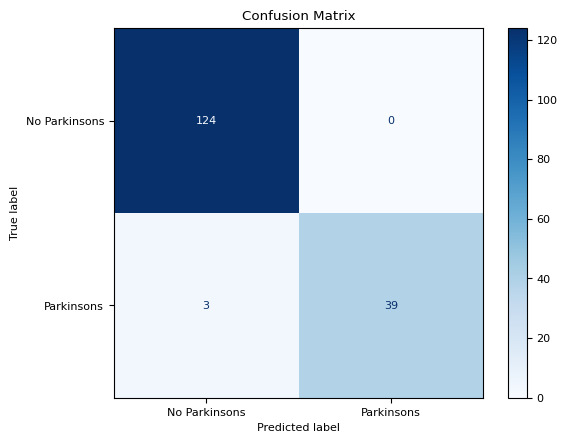

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.utils import class_weight
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# === Step 1: Load Dataset ===
data_dir = "/kaggle/input/parkinsons-brain-mri-dataset/parkinsons_dataset"
batch_size = 32
img_size = (224, 224)
seed = 42

train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

# === Step 2: Data Augmentation & Normalization ===
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(data_augmentation(x, training=True)), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# === Step 3: Class Weights ===
raw_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)
y_train = np.concatenate([y.numpy() for _, y in raw_ds])
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: w for i, w in enumerate(weights)}

# === Step 4: Custom Focal Loss ===
def focal_loss(alpha=0.25, gamma=2.0):
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1. - tf.keras.backend.epsilon())
        cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        weight = alpha * y_true * tf.pow(1 - y_pred, gamma) + (1 - alpha) * (1 - y_true) * tf.pow(y_pred, gamma)
        return tf.reduce_mean(weight * cross_entropy)
    return loss_fn

# === Step 5: AlexNet Model (Modified for 224x224) ===
def build_alexnet(input_shape=(224, 224, 3)):
    model = models.Sequential([
        layers.Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=2),

        layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3, 3), strides=2),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(3, 3), strides=2),

        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    return model

model = build_alexnet()

# === Step 6: Compile ===
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=focal_loss(alpha=0.25, gamma=2.0),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# === Step 7: Checkpoint & LR Scheduler ===
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "alexnet_best_model.keras",
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# === Step 8: Train ===
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weights,
    callbacks=[checkpoint_cb, reduce_lr_cb]
)

# === Step 9: Evaluate ===
val_loss, val_acc, val_auc = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc * 100:.2f}%, AUC: {val_auc:.4f}, Loss: {val_loss:.4f}")


# === Step 10: Confusion Matrix ===
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype("int32").flatten())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Parkinsons', 'Parkinsons'])

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 108.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 112.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 114.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.2 MB/s eta 0:00:00


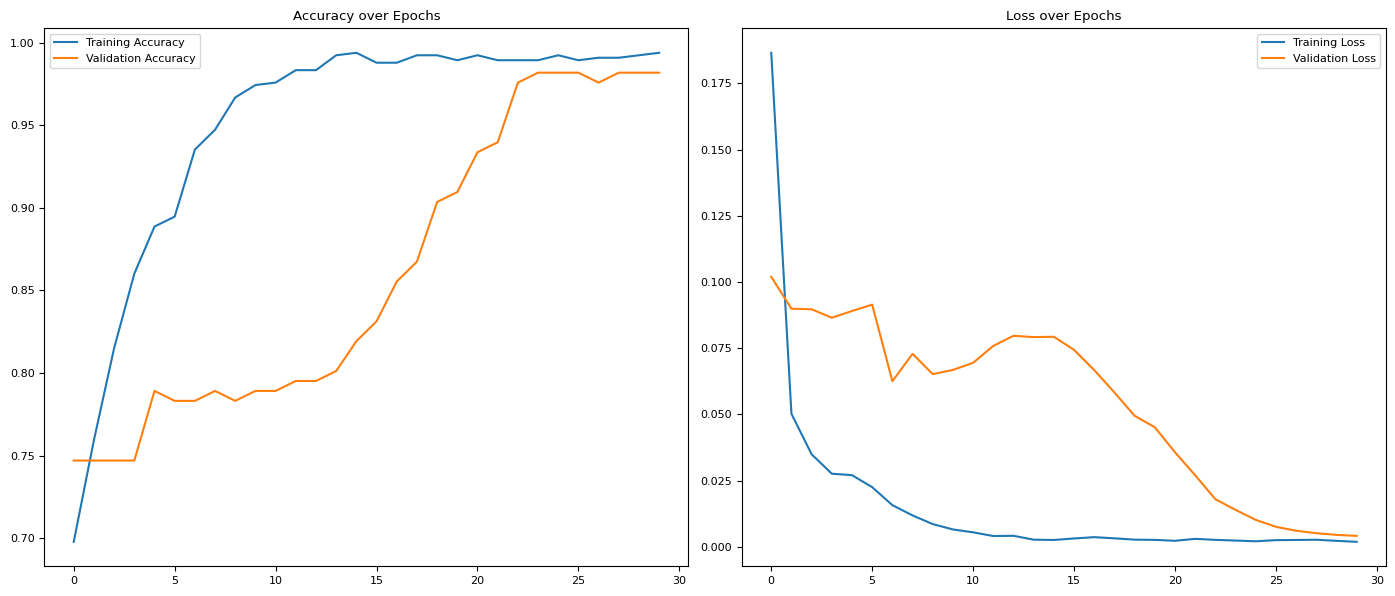

In [ ]:
# === Step 11: Plot Accuracy and Loss ===
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Save the complete model after training (final state)
model.save("alexnet_final_model.keras")


In [ ]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 54, 54, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 54, 54, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 26, 26, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    26,218,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 140,256,133 (535.03 MB)

 Trainable params: 46,751,809 (178.34 MB)

 Non-trainable params: 704 (2.75 KB)

 Optimizer params: 93,503,620 (356.69 MB)

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os

# Upload the image
uploaded = files.upload()

# Predict the first image uploaded
for img_name in uploaded.keys():
    img_path = img_name

    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make prediction
    prediction = model.predict(img_array)[0][0]

    # Display results
    plt.imshow(img)
    plt.axis('off')
    plt.title("Parkinson's Detected" if prediction > 0.5 else "No Parkinson's")
    plt.show()

    print(f"Confidence: {prediction:.2f}" if prediction > 0.5 else f"Confidence: {1 - prediction:.2f}")


Saving parkinson.png to parkinson.png


NameError: name 'model' is not defined

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, Activation

# Build the model
model = Sequential()

# 1st Convolution Block
model.add(Conv2D(96, (3, 3), padding='valid', input_shape=(56, 56, 3)))  # Assuming RGB images
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd Convolution Block
model.add(Conv2D(256, (3, 3), padding='valid'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd Convolution Block
model.add(Conv2D(384, (3, 3), padding='valid'))
model.add(Activation('relu'))

# 4th Convolution Block
model.add(Conv2D(384, (3, 3), padding='valid'))
model.add(Activation('relu'))

# 5th Convolution Block
model.add(Conv2D(256, (3, 3), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten Layer
model.add(Flatten())

# Fully Connected Layers
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(1, activation='sigmoid'))  # For binary classification

# Print model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 54, 54, 96)     │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 54, 54, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 54, 54, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 25, 256)    │       221,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25, 25, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 10, 10, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 8, 8, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     9,441,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,549,825 (112.72 MB)

 Trainable params: 29,549,121 (112.72 MB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 117.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 117.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 120.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.4 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Define the model
model = Sequential()

# Input Layer + Conv Block 1
model.add(Conv2D(96, (3, 3), padding='same', input_shape=(56, 56, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Block 2
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Block 3
model.add(Conv2D(384, (3, 3), padding='same'))
model.add(Activation('relu'))

# Conv Block 4
model.add(Conv2D(384, (3, 3), padding='same'))
model.add(Activation('relu'))

# Conv Block 5
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and Dense Layers
model.add(Flatten())
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(1))
model.add(Activation('sigmoid'))

# Summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 96)     │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 56, 56, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 28, 28, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       221,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 14, 14, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 14, 14, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │    51,384,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         4,097 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 1)              │             

 Total params: 71,492,865 (272.72 MB)

 Trainable params: 71,492,161 (272.72 MB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
from graphviz import Digraph

# Create a new directed graph
flowchart = Digraph(comment='Parkinsons MRI Classification Project')

# Start node (ellipse + light green)
flowchart.node('Start', 'Start', shape='ellipse', style='filled', fillcolor='lightgreen')

# Steps (rectangles + light blue)
flowchart.attr('node', shape='box', style='filled', fillcolor='lightblue')

flowchart.node('A', 'Load Dataset\n(image_dataset_from_directory)')
flowchart.node('B', 'Data Augmentation\n(RandomFlip, Rotation, etc.)\n+ Normalization (Rescale)')
flowchart.node('C', 'Compute Class Weights\n(Sklearn)')
flowchart.node('D', 'Define Focal Loss\n(alpha=0.25, gamma=2.0)')
flowchart.node('E', 'Build Modified AlexNet\n(Conv, BatchNorm, Pool, Dense)')
flowchart.node('F', 'Compile Model\n(Adam Optimizer, Focal Loss, Accuracy, AUC)')
flowchart.node('G', 'Set Callbacks\n(ModelCheckpoint, ReduceLROnPlateau)')
flowchart.node('H', 'Train Model\n(30 Epochs, Class Weights)')
flowchart.node('I', 'Evaluate on Validation Set\n(Print Accuracy, AUC, Loss)')

# Stop node (ellipse + light red)
flowchart.attr('node', shape='ellipse', style='filled', fillcolor='lightcoral')
flowchart.node('Stop', 'Stop')

# Connect nodes
flowchart.edges([
    ('Start', 'A'),
    ('A', 'B'),
    ('B', 'C'),
    ('C', 'D'),
    ('D', 'E'),
    ('E', 'F'),
    ('F', 'G'),
    ('G', 'H'),
    ('H', 'I'),
    ('I', 'Stop')
])

# Render the diagram
flowchart.render('parkinsons_mri_flowchart', format='png', cleanup=True)
print("Colorful flowchart created and saved as 'parkinsons_mri_flowchart.png'.")


Colorful flowchart created and saved as 'parkinsons_mri_flowchart.png'.


In [ ]:
from graphviz import Digraph

# Create a new directed graph
flowchart = Digraph(comment='Parkinsons MRI Classification Project')

# Start node (ellipse + light green)
flowchart.node('Start', 'Start', shape='ellipse', style='filled', fillcolor='lightgreen')

# Steps (rectangles + light blue)
flowchart.attr('node', shape='box', style='filled', fillcolor='lightblue')

flowchart.node('A', 'Load Dataset\n(image_dataset_from_directory)')
flowchart.node('B', 'Data Augmentation\n(RandomFlip, Rotation, etc.)\n+ Normalization (Rescale)')
flowchart.node('C', 'Compute Class Weights\n(Sklearn)')
flowchart.node('D', 'Define Focal Loss\n(alpha=0.25, gamma=2.0)')

# Condition node (diamond + yellow)
flowchart.attr('node', shape='diamond', style='filled', fillcolor='lightyellow')
flowchart.node('Cond1', 'Is custom loss ready?')

# Back to normal steps (rectangles + light blue)
flowchart.attr('node', shape='box', style='filled', fillcolor='lightblue')

flowchart.node('E', 'Build Modified AlexNet\n(Conv, BatchNorm, Pool, Dense)')
flowchart.node('F', 'Compile Model\n(Adam Optimizer, Focal Loss, Accuracy, AUC)')
flowchart.node('G', 'Set Callbacks\n(ModelCheckpoint, ReduceLROnPlateau)')
flowchart.node('H', 'Train Model\n(30 Epochs, Class Weights)')
flowchart.node('I', 'Evaluate on Validation Set\n(Print Accuracy, AUC, Loss)')

# Stop node (ellipse + light red)
flowchart.attr('node', shape='ellipse', style='filled', fillcolor='lightcoral')
flowchart.node('Stop', 'Stop')

# Connect nodes
flowchart.edge('Start', 'A')
flowchart.edge('A', 'B')
flowchart.edge('B', 'C')
flowchart.edge('C', 'D')
flowchart.edge('D', 'Cond1')

# Add labeled edge for "Yes" path
flowchart.edge('Cond1', 'E', label='Choose Best Model')

# Continue normal flow
flowchart.edge('E', 'F')
flowchart.edge('F', 'G')
flowchart.edge('G', 'H')
flowchart.edge('H', 'I')
flowchart.edge('I', 'Stop')

# Add feedback loop: I -> Cond1
flowchart.edge('I', 'Cond1', label='Retrain if needed', style='dashed')

# Render the diagram
flowchart.render('parkinsons_mri_flowchart', format='png', cleanup=True)
print("Flowchart with loop (I ➔ Cond1) added and saved as 'parkinsons_mri_flowchart.png'.")


Flowchart with loop (I ➔ Cond1) added and saved as 'parkinsons_mri_flowchart.png'.


In [ ]:
from graphviz import Digraph
from PIL import Image

# Recreate the directed graph with all nodes and connections
dot = Digraph(comment='Parkinsons MRI Classification Flowchart', node_attr={'style': 'filled'})

# Add nodes
dot.node('S', 'Start', shape='ellipse', color='lightgreen', width='3', height='1.2')
dot.node('A', 'Load Dataset (image_dataset_from_directory)', shape='rectangle', color='lightblue', width='3', height='1.2')
dot.node('B', 'Data Augmentation (RandomFlip, Rotation, etc.) + Normalization (Rescale)', shape='rectangle', color='lightblue', width='3', height='1.2')
dot.node('C', 'Compute Class Weights (Sklearn)', shape='rectangle', color='lightblue', width='3', height='1.2')
dot.node('D', 'Define Focal Loss (alpha=0.25, gamma=2.0)', shape='rectangle', color='lightblue', width='3', height='1.2')
dot.node('Cond1', 'Is custom loss ready?', shape='diamond', color='yellow', height='2.5', width='2.5')
dot.node('E', 'Build Modified AlexNet (Conv, BatchNorm, Pool, Dense)', shape='rectangle', color='lightblue', width='3', height='1.2')
dot.node('F', 'Compile Model (Adam Optimizer, Focal Loss, Accuracy, AUC)', shape='rectangle', color='lightblue', width='3', height='1.2')
dot.node('G', 'Set Callbacks (ModelCheckpoint, ReduceLROnPlateau)', shape='rectangle', color='lightblue', width='3', height='1.2')
dot.node('H', 'Train Model (30 Epochs, Class Weights)', shape='rectangle', color='lightblue', width='3', height='1.2')
dot.node('I', 'Evaluate on Validation Set (Print Accuracy, AUC, Loss)', shape='rectangle', color='lightblue', width='3', height='1.2')
dot.node('FlaskAPI', 'Flask API', shape='rectangle', color='lightcoral', width='3', height='1.2')  # Flask API node
dot.node('Frontend', 'Frontend (Display Results, User Interaction)', shape='rectangle', color='lightyellow', width='3', height='1.2')  # Frontend node
dot.node('UploadMRI', 'Upload MRI', shape='rectangle', color='lightgreen', width='3', height='1.2')  # Upload MRI node
dot.node('Condition', 'Condition (Is there any error?)', shape='diamond', color='yellow', height='2.5', width='2.5')  # Condition node
dot.node('Healthy', 'Healthy (No)', shape='ellipse', color='lightgreen', width='3', height='1.2')  # Healthy node
dot.node('Unhealthy', 'Unhealthy (Yes)', shape='ellipse', color='lightcoral', width='3', height='1.2')  # Unhealthy node
dot.node('Stop', 'Stop', shape='ellipse', color='lightgreen', width='3', height='1.2')

# Add invisible node to create space between Start and Flask API columns
dot.node('Invisible1', '', shape='point', width='0', height='0')

# Add edges (arrows)
dot.edge('S', 'A')
dot.edge('A', 'B')
dot.edge('B', 'C')
dot.edge('C', 'D')
dot.edge('D', 'Cond1')
dot.edge('Cond1', 'E', label='Choose Best Model', color='blue')
dot.edge('E', 'F')
dot.edge('F', 'G')
dot.edge('G', 'H')
dot.edge('H', 'I')
dot.edge('I', 'FlaskAPI', label='Send results to Flask API', color='blue')  # Connection to Flask API

# Add bidirectional arrow between Flask API and Frontend
dot.edge('FlaskAPI', 'Frontend', dir='both', label='Communicate with', color='purple')

# Add bidirectional arrow between Frontend and Upload MRI
dot.edge('Frontend', 'UploadMRI', dir='both', label='Upload and Retrieve MRI', color='blue')

# Add arrow between Upload MRI and Condition
dot.edge('UploadMRI', 'Condition', label='Check MRI Upload', color='green')

# Add edges between Condition and Healthy/Unhealthy nodes
dot.edge('Condition', 'Healthy', label='No', color='green')  # Healthy path
dot.edge('Condition', 'Unhealthy', label='Yes', color='red')  # Unhealthy path

# Add edges from Healthy and Unhealthy to Stop
dot.edge('Healthy', 'Stop', label='Healthy Path', color='green')
dot.edge('Unhealthy', 'Stop', label='Unhealthy Path', color='red')

# Create a subgraph to align Flask API in B row
with dot.subgraph() as s:
    s.attr(rank='same')  # Nodes in this subgraph will be aligned in the same row
    s.node('B')
    s.node('Invisible1')  # Add invisible node here
    s.node('FlaskAPI')

# Create a subgraph to align Frontend in C row
with dot.subgraph() as s:
    s.attr(rank='same')  # Nodes in this subgraph will be aligned in the same row
    s.node('C')
    s.node('Frontend')

# Create a subgraph to align Upload MRI in D row
with dot.subgraph() as s:
    s.attr(rank='same')  # Nodes in this subgraph will be aligned in the same row
    s.node('D')
    s.node('UploadMRI')

# Create a subgraph to align Condition in Cond1 row
with dot.subgraph() as s:
    s.attr(rank='same')  # Nodes in this subgraph will be aligned in the same row
    s.node('Cond1')
    s.node('Condition')

# Add the new connection between I (Evaluate on Validation Set) and Cond1 (Is custom loss ready?)
dot.edge('I', 'Cond1', label='Evaluate Results', color='blue')

# Render the updated graph without the black dot (invisible node)
dot.render('parkinsons_mri_flowchart_with_space', format='png', cleanup=True)

# Display the updated flowchart (if running in a Jupyter notebook)
img = Image.open('parkinsons_mri_flowchart_with_space.png')
img.show()


In [ ]:
!pip install graphviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.5 MB/s eta 0:00:00
